# Representation Learning and Generative Learning using AutoEncoders and GANs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl

import os
import time
import imageio
from IPython import display
import glob
import PIL

2024-12-23 15:40:08.391606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 15:40:09.874940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Efficient Data Representation

## Performing PCA with an undercomplete linear AutoEncoder

The following code builds a simple linear AE to perform PCA on a 3D dataset, projecting it to 2D:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')

In [3]:
# build 3D dataset
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

In [13]:
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [ ]:
# let's build AE

encoder = keras.models.Sequential(
    [keras.layers.Input(shape=[3]), keras.layers.Dense(2)]
)
decoder = keras.models.Sequential(
    [keras.layers.Input(shape=[2]), keras.layers.Dense(3)]
)

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_r=1.5))

This code is not really different from all the MLPs that we have built, but there are few things to note:

- We organized the AE into two subcomponents: the encoder and the decoder. Both regular `Sequential` models with single `Dense` layer each.
- To perform PCA, we do not use any activation function (i.e., all neurons are linear), and the cost function is MSE. 

Now let's train model on simple generated 3D dataset and use it to encode that same dataset (i.e., project to 2D)

In [16]:
h = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2894  
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0497 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━

In [17]:
codings = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


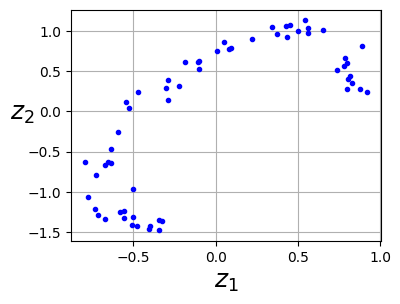

In [19]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:,1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## Stacked AutoEncoders

### Implementing Stacked AutoEncoders using Keras

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [4]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5))

h = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-19 13:44:28.025679: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.
2024-12-19 13:44:28.228726: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3796 - val_loss: 0.3103
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3070 - val_loss: 0.3043
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2991 - val_loss: 0.2969
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2944 - val_loss: 0.2928
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2918 - val_loss: 0.2964
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2899 - val_loss: 0.2901
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2879 - val_loss: 0.2882
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2863 - val_loss: 0.2875
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2854 - val_loss: 0.2944
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2849 - val_loss: 0.2864


### Visualizing the Reconstruction

In [12]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [11]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
# show_constructions(stacked_ae)

### Visualizing the Fashion MNIST Dataset

Strategy: Use the autoencoder to reduce the dimensionality down to reasonable size then use another dimensionality reduction technique to reduce it further for visualization.

In [11]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


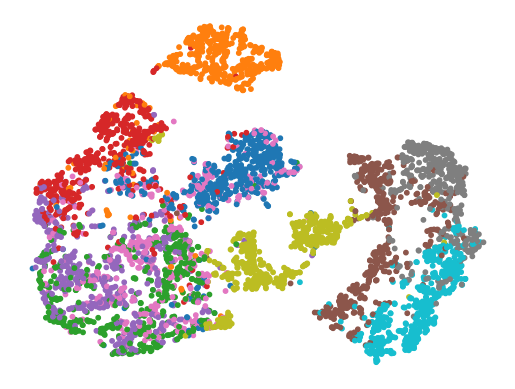

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

### Unsupervised Pretraining Using Stacked AutoEncoders

## Techniques for Training Stacked AutoEncoders

### Tying Weights

To tie weights between layers using Keras, let's define a custom layer:

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros", shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)
    
dense1 = keras.layers.Dense(100, activation="selu")
dense2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense1,
    dense2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense2, activation="selu"),
    DenseTranspose(dense1, activation="sigmoid"),
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

### Training One AutoEncoder at a Time

Instead of training the whole stacked ae in one go like we did, it is possible to train one shallow ae at a time, then stack all of them into a single stacked ae. This is called greedy layer-wise training.

In [16]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    
    ae = keras.models.Sequential([encoder, decoder])
    ae.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    ae.fit(X_train, X_train, epochs=epochs, validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train)
X_valid_flat = K.batch_flatten(X_valid)

enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100, X_train_flat, X_valid_flat, "binary_crossentropy", keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid")

enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05), output_activation="selu")

Epoch 1/10


2024-12-19 14:40:18.734998: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.
2024-12-19 14:40:18.898481: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.
/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3965 - val_loss: 0.3112
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3054 - val_loss: 0.2995
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2955 - val_loss: 0.2928
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2895 - val_loss: 0.2884
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2855 - val_loss: 0.2854
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2827 - val_loss: 0.2832
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2806 - val_loss: 0.2814
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2790 - val_loss: 0.2800
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2776 - val_loss: 0.2788
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2764 - val_loss: 0.2778
Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.1607 - val_loss: 0.3984
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 

In [18]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


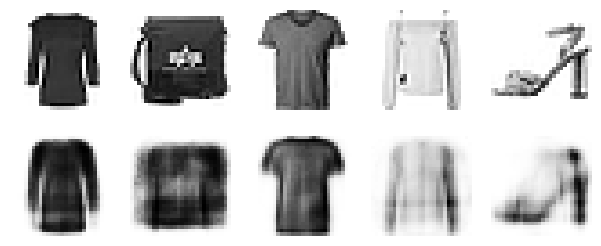

In [19]:
show_constructions(stacked_ae_1_by_1)
plt.show()

In [20]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.1))
h = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

2024-12-19 14:43:34.069487: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2868 - val_loss: 0.2884
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2862 - val_loss: 0.2881
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2859 - val_loss: 0.2879
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2857 - val_loss: 0.2877
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2855 - val_loss: 0.2875
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2853 - val_loss: 0.2873
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2852 - val_loss: 0.2872
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2850 - val_loss: 0.2870
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2849 - val_loss: 0.2869
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2847 - val_loss: 0.2868


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


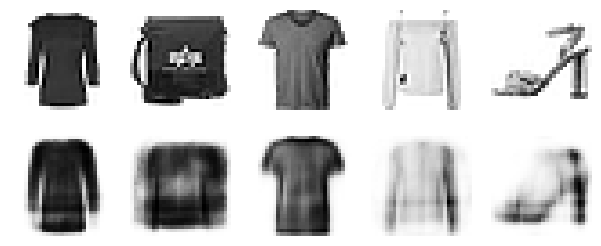

In [21]:
show_constructions(stacked_ae_1_by_1)
plt.show()

## Convolutional AutoEncoders

In [23]:
conv_encoder = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Reshape([28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Input(shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu"),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,296 (91.00 KB)

 Trainable params: 23,296 (91.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_3              │ (None, 7, 7, 32)       │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           145 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,233 (90.75 KB)

 Trainable params: 23,233 (90.75 KB)

 Non-trainable params: 0 (0.00 B)

## Recurrent AutoEncoders

Encoder = sequence to vector

Decoder = vector to sequence

In [24]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/layers/reshaping/repeat_vector.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Denoising AutoEncoders

In [25]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0))
h = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4047 - val_loss: 0.3224
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3202 - val_loss: 0.3124
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3134 - val_loss: 0.3092
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3095 - val_loss: 0.3076
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3067 - val_loss: 0.3021
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3048 - val_loss: 0.3004
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3032 - val_loss: 0.2992
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3019 - val_loss: 0.2975
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3008 - val_loss: 0.2969
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3000 - val_loss: 0.2966


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


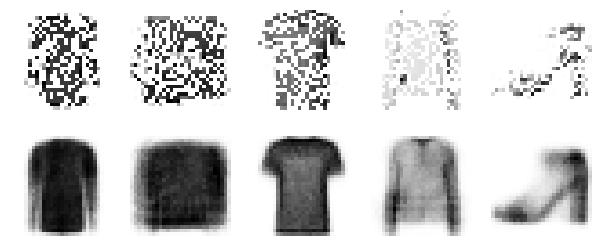

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

Thus AE can guess the things which are missing in the input data. This is useful for denoising or removing noise from the data.

## Sparse AutoEncoders

Let's build simple ae to compare with the sparse ae.

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.))
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-19 20:53:17.481681: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.
2024-12-19 20:53:17.766792: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4891 - val_loss: 0.3790
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3694 - val_loss: 0.3551
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3466 - val_loss: 0.3372
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3314 - val_loss: 0.3260
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3223 - val_loss: 0.3216
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3184 - val_loss: 0.3192
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.3159 - val_loss: 0.3168
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3137 - val_loss: 0.3140
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3113 - val_loss: 0.3116
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3092 - val_loss: 0.3096


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


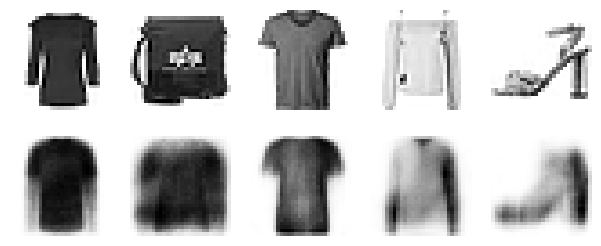

In [7]:
show_reconstructions(simple_ae)

Functions to create nice activation histograms

In [11]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [10]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

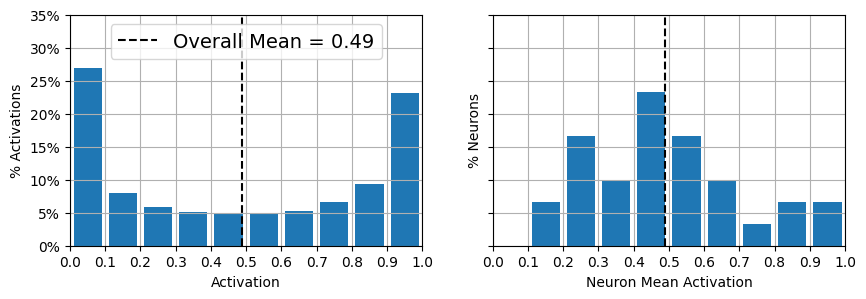

In [11]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

In [6]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Input(shape=[28,28]),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Input(shape=[300]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0))
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

2024-12-21 17:43:04.783296: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.
2024-12-21 17:43:04.977628: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6207 - val_loss: 0.4934
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.4902 - val_loss: 0.4929
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.4899 - val_loss: 0.4928
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.4898 - val_loss: 0.4927
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.4898 - val_loss: 0.4927
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4897 - val_loss: 0.4927
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.4897 - val_loss: 0.4927
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4897 - val_loss: 0.4927
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4897 - val_loss: 0.4927
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.4897 - val_loss: 0.4926


The `ActivityRegularization` layer just returns its inputs, but as a side effect it adds a training loss equal to the sum of absolute values of its inputs (this layer only has an effect during training). This penalty will encourage the neural network to produce codings close to 0, but since it will also be penalized if it does not reconstruct the inputs correctly, it will have to output at least a few non zero values. Using l1 norm rather than l2 norm will push the neural network to preserve the most important codings while eliminating the ones that are not needed for input image (rather than just reducing all codings). 

Another approach, which often yields better results, is to measure the actual sparsity of the coding layer at each iteration, and penalize the model when the measured sparsity differs from the target sparsity. We do so by computing the average activation of each neuron in the coding layer, over the whole training batch. The batch size must not be too small or else the mean will not be accurate.

Once we have the mean activation per neuron, we want to penalize the neurons that are too active, or not active enough, by adding a sparsity loss to the cost function. For eg: if we measure that a neuron has an average activation of 0.3, but the target sparsity is 0.1, it must be penalized to active less. One approach could be simply adding the squared error (0.3 - 0.1)^2 to the cost function, but in practice a better approach is to use Kullback-Leibler divergence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


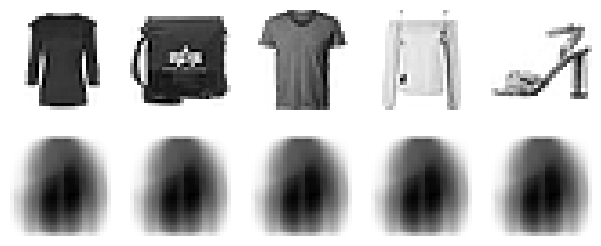

In [14]:
show_reconstructions(sparse_l1_ae)

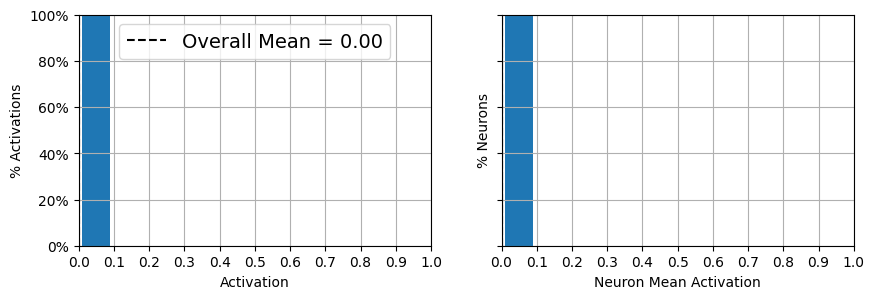

In [12]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

We now have all we need to implement a sparse autoencoder based on the
KL divergence. First, let’s create a custom regularizer to apply KL
divergence regularization:

In [17]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

Now we can build the sparse autoencoder, using the
`KLDivergenceRegularizer` for the coding layer’s activations:

In [18]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Input(shape=[28,28]),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Input(shape=[300]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0))
history = sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

2024-12-21 18:02:13.526436: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/10


2024-12-21 18:02:13.917834: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6542 - val_loss: 0.4317
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3941 - val_loss: 0.4053
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.3791 - val_loss: 0.3843
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.3616 - val_loss: 0.3724
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.3502 - val_loss: 0.3635
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3411 - val_loss: 0.3554
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3349 - val_loss: 0.3508
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3313 - val_loss: 0.3472
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3287 - val_loss: 0.3448
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3265 - val_loss: 0.3436


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


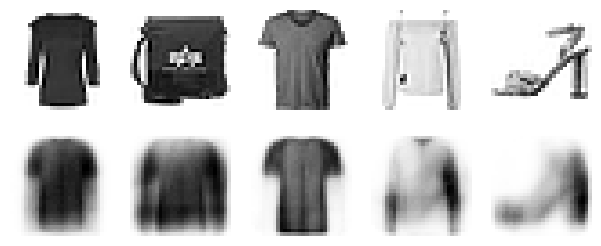

In [19]:
show_reconstructions(sparse_kl_ae)

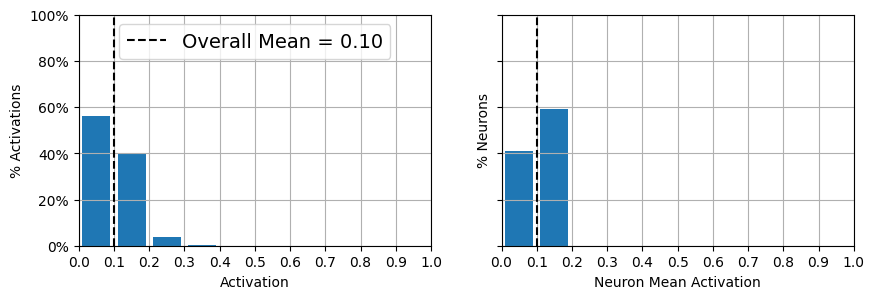

In [20]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

the activations of the neurons in the coding layer are mostly close to 0 (about 70% of all
activations are lower than 0.1), and all neurons have a mean activation
around 0.1 (about 90% of all neurons have a mean activation between 0.1
and 0.2) as shown above

## Variational AutoEncoders

Let's start building variational autoencoder for Fashion MNIST. Firt we need a custom layer to sample the codings given mean and gamma (log sigma^2).

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [5]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

The `Sampling` layer takes two inputs: mean $\mu$ and `log_var` ($\gamma = \log(\sigma^2)$). It uses function `K.random_normal()` to sample a random vector (of the same shape as $\gamma$) from the Normal distribution with mean 0 and standard deviation 1. It then multiplies it by $\exp(\gamma/2)$ (which is equal to $\sigma$) and it finally adds $\mu$ and returns the result.

Next, we create the encoder using the Functional API because model is not entirely sequential. The encoder outputs both `mean` and `log_var` (instead of just the codings). The decoder is a simple sequential model.

In [6]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]) # we will only use codings output but for inspection purposes we have kept codings_mean and codings_log_var as well.

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# lastly we must add latent loss and reconstruction loss
# Define latent loss as a Keras layer
class LatentLossLayer(keras.layers.Layer):
    def call(self, inputs):
        codings_mean, codings_log_var = inputs
        latent_loss = -0.5 * K.sum(
            1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
            axis=-1
        )
        self.add_loss(K.mean(latent_loss) / 784.)  # Scale to match reconstruction loss
        return codings_mean  # Dummy output, not used

latent_loss_layer = LatentLossLayer()([codings_mean, codings_log_var])

variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# Compile the model
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")
# Train the model
h = variational_ae.fit(
    X_train, X_train,
    epochs=25,
    batch_size=128,
    validation_data=(X_valid, X_valid)
)

2024-12-22 15:46:37.052644: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.
2024-12-22 15:46:37.288910: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.4205 - val_loss: 0.3294
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3226 - val_loss: 0.3222
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3134 - val_loss: 0.3109
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3079 - val_loss: 0.3076
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3038 - val_loss: 0.3051
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3009 - val_loss: 0.3026
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2988 - val_loss: 0.3018
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2972 - val_loss: 0.2989
Epoch 9/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2957 - val_loss: 0.2965
Epoch 10/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2945 - val_loss: 0.2961
Epoch 11/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2935 - val_loss: 0.2951
Epoch 12/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 1

### Generating Fashion MNIST Images

Now let's use variational ae to generate images that look like fashion items. All we need to do is sample random codings from a gaussian distribution and decode them:

In [8]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [9]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

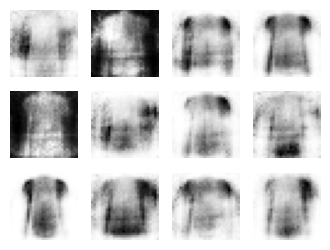

In [10]:
plot_multiple_images(images, 4)

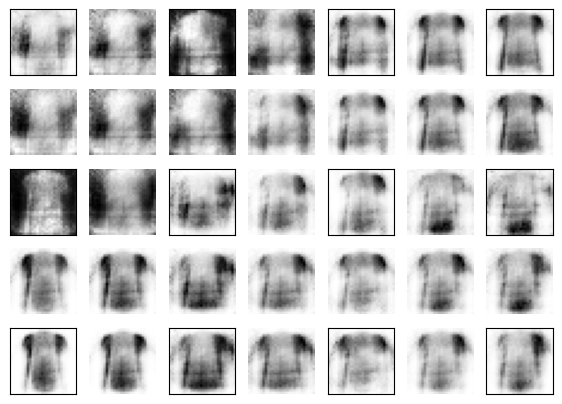

In [14]:
codings_grid = tf.reshape(codings, [1,3,4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5,7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

## Generative Adversarial Networkss

Let's build a simple GAN for fashion MNIST.

First we need to build the generator and the discriminator. The generator is similar to an autoencoder's decoder, and the discriminator is a regular binary classifier. For second phase of each training iteration, we also need the full GAN model containing generator followed by discriminator.

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Input(shape=[codings_size]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Flatten(),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

Next, we need to compile these models. As discriminator is binary classifier, we can naturally use binary crossentropy loss. The generator will be trained using the `gan` model, so we do not need to compile it separately.
The `gan` model is also binary classifier, so it can use the binary cross entropy loss. Imporantly, the discriminator should not be trained during the second phase, so we make it non-trainable before compiling the `gan` model.

In [16]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

Since training loop is unusual, we cannot use the regular `fit()` method. Instead, we will write a custom training loop. For this, we first need to create a `Dataset` to iterate through the images:

In [17]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

2024-12-22 17:15:04.605926: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))  
        for X_batch in dataset:
            # phase-1: training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # phase-2: training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1) # training on kaggle

Result produced on kaggle after first epoch:

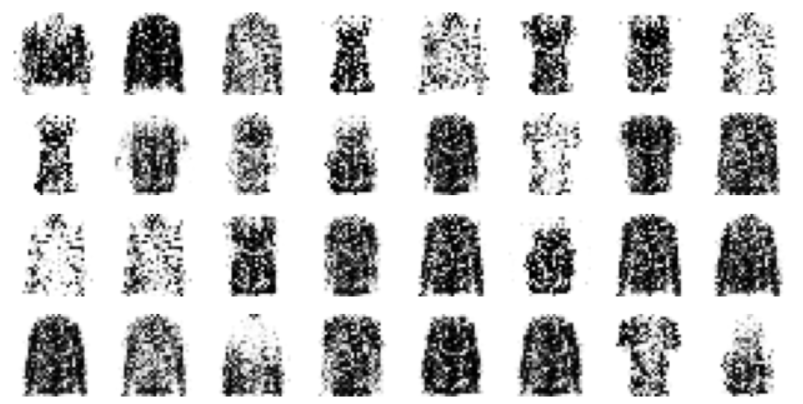

We see that the images already start to look like (versy noisy) Fashion MNIST images. Unfortunately, the images never get much better than this. Training GANs can be challenging, here's why:

### The Difficulties of Training GANs

### Deep Convolutional GANs

The main guidelines they proposed for building stable convolutional GANs are:

- Replace any pooling layers with strided convolutions (in the discriminator) and transposed convolutions (in the generator).
- Use Batch Normalization in both the generator and the discriminator, except in the generator’s output layer and the discriminator’s input layer.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in the generator for all layers except the output layer, which should use tanh.
- Use Leaky ReLU activation in the discriminator for all layers.

These guidelines will work in many cases, but not always, so you may still
need to experiment with different hyperparameters (in fact, just changing
the random seed and training the same model again will sometimes work)

In [12]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Input(shape=[codings_size]),
    keras.layers.Dense(7 * 7 * 128),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh")
])

discriminator = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28, 1]),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

The generator takes coding size of 100, and it projects them to 6272 dimensions (7*7*128), and reshape the result to get a 7x7x128 tensor. This tensor is batch normalized and fed to a transposed convolutional layer with a stride of 2, which upsamples it from 7x7 to 14x14 and reduces its depth from 128 to 64. The result is batch normalized again and fed to another transposed convolutional layer with a stride of 2, which upsamples it from 14x14 to 28x28 and reduces the depth from 64 to 1. This layer uses the tanh activation function, so the outputs will range from -1 to 1. For this reason, before training the GAN, we need to rescale the training set to the same range. We also need to reshape it to add the channel dimension:

In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

The disscriminator looks much like a regular CNN for binary classification, except instead of max pooling layes to downsample the image, we use strided convolution (`strides=2`). Also note that we use LeakyReLU activation function in the discriminator.

Now let's compile and train the DCGAN:

In [16]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE,
                                                                                    drop_remainder=True).prefetch(1)

2024-12-23 17:25:46.860811: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


2024-12-23 17:25:48.869734: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.
2024-12-23 17:25:49.085522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


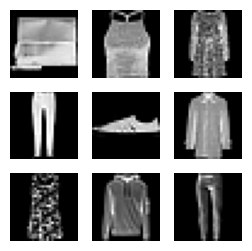

In [17]:
plt.figure(figsize=(3, 3))
for images in train_dataset.take(1):  # Take one batch from the dataset
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis("off")
plt.show()

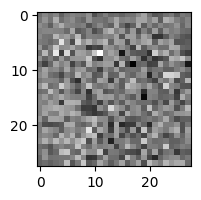

In [19]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.figure(figsize=(2, 2))
plt.imshow(generated_image[0, :, :, 0], cmap='gray');

In [20]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4994404]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0005)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
train(train_dataset, epochs=EPOCHS)

In [ ]:
anim_file = 'dcgan_fashiomnist.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Result after training for 50 epochs:

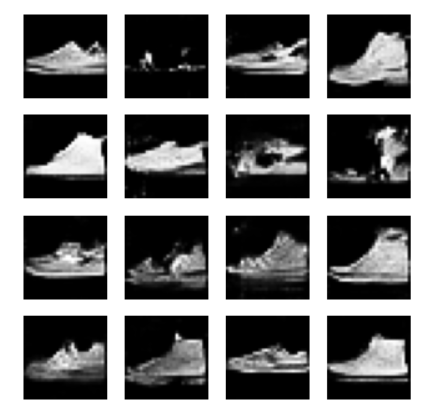

DCGANs aren’t perfect, though. For example, when you try to generate
very large images using DCGANs, you often end up with locally
convincing features but overall inconsistencies (such as shirts with one
sleeve much longer than the other). How can you fix this?

### Progressive Growing GANs